In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input/aptos2019-blindness-detection'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import random

/kaggle/input/aptos2019-blindness-detection/sample_submission.csv
/kaggle/input/aptos2019-blindness-detection/train.csv
/kaggle/input/aptos2019-blindness-detection/test.csv
/kaggle/input/aptos2019-blindness-detection/train_images/ef476be214d4.png
/kaggle/input/aptos2019-blindness-detection/train_images/6dcde47060f9.png
/kaggle/input/aptos2019-blindness-detection/train_images/ec363f48867b.png
/kaggle/input/aptos2019-blindness-detection/train_images/17f6c7072f61.png
/kaggle/input/aptos2019-blindness-detection/train_images/b49b2fac2514.png
/kaggle/input/aptos2019-blindness-detection/train_images/af6166d57f13.png
/kaggle/input/aptos2019-blindness-detection/train_images/8d13c46e7d75.png
/kaggle/input/aptos2019-blindness-detection/train_images/c3b15bf9b4bc.png
/kaggle/input/aptos2019-blindness-detection/train_images/be68322c7223.png
/kaggle/input/aptos2019-blindness-detection/train_images/88e4399d207c.png
/kaggle/input/aptos2019-blindness-detection/train_images/0243404e8a00.png
/kaggle/input

Metric Helper

In [2]:
# Necessary utility modules and libraries
import os
import shutil
import random
import cv2

# Plotting libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.signal import gaussian, convolve2d
import seaborn as sns

# Libraries for building the model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, regularizers
from tensorflow.keras.applications import DenseNet121, ResNet50, InceptionV3, EfficientNetB7, EfficientNetB0, DenseNet169
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2, l1
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score, confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
classes = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']

In [4]:
dir_path = '/kaggle/input/aptos2019-blindness-detection'
os.listdir(dir_path)

['sample_submission.csv',
 'train_images',
 'train.csv',
 'test.csv',
 'test_images']

In [5]:
df_train = pd.read_csv("/kaggle/input/aptos2019-blindness-detection/train.csv").sample(frac=1, random_state=42)
df_test = pd.read_csv("/kaggle/input/aptos2019-blindness-detection/test.csv").sample(frac=1, random_state=42)

In [6]:
len(df_train), len(df_test)

(3662, 1928)

In [7]:
df_train.sample(5)

,id_code,diagnosis
3095,d7ac4a0c9760,0
129,09935d72892b,1
2693,ba25f947f4ec,2
1760,7c52fe73e748,2
1631,7347f5133a6a,1


In [8]:
df_train['diagnosis'].value_counts()

diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64

In [9]:
class_code = {0: "No_DR",
              1: "Mild",
              2: "Moderate",
              3: "Severe",
              4: "Proliferate_DR"}

In [10]:
def mapping_temp(df, root=dir_path):
    df['label'] = list(map(class_code.get, df['diagnosis']))
    df['path'] = [i[1]['label']+'/'+i[1]['id_code']+'.png' for i in df.iterrows()]
    return df

df_train = mapping_temp(df_train)
df_train

,id_code,diagnosis,label,path
2059,90960ddf4d14,0,No_DR,No_DR/90960ddf4d14.png
1105,4e0656629d02,1,Mild,Mild/4e0656629d02.png
818,3b018e8b7303,3,Severe,Severe/3b018e8b7303.png
1237,55eb405ec71e,4,Proliferate_DR,Proliferate_DR/55eb405ec71e.png
463,207dd0487264,0,No_DR,No_DR/207dd0487264.png
...,...,...,...,...
1130,4f6abc40c72d,0,No_DR,No_DR/4f6abc40c72d.png
1294,5a091e8cd95c,1,Mild,Mild/5a091e8cd95c.png
860,3dfc50108072,2,Moderate,Moderate/3dfc50108072.png
3507,f47a2a4a0411,1,Mild,Mild/f47a2a4a0411.png


In [11]:
# Dropping the diagnosis column because the model assigns different codes for prediction
df_train.drop(['diagnosis'], axis=1, inplace=True)

In [12]:
df_train['label'].value_counts()

label
No_DR             1805
Moderate           999
Mild               370
Proliferate_DR     295
Severe             193
Name: count, dtype: int64

In [13]:
import os
import shutil

input_folder = '/kaggle/input/train-images/aadi_preprocess'
output_folder = '/kaggle/working/new_train_images/'

# Ensure the output directory exists
os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(input_folder):
    if filename.endswith('.png'):
        # Extract the random ID from the filename
        random_id = filename.split('_')[-1][:-4]  # Extracting the ID from 'preprocessed_somerandomid.png'
        
        # Create the new filename
        new_filename = f'{random_id}.png'
        
        # Rename the file and move it to the output directory
        shutil.copy(os.path.join(input_folder, filename), os.path.join(output_folder, new_filename))

In [14]:
for i in range(5):
  os.mkdir('./'+class_code[i])

In [15]:
df_train['label'].value_counts()

label
No_DR             1805
Moderate           999
Mild               370
Proliferate_DR     295
Severe             193
Name: count, dtype: int64

In [16]:
import os
import shutil
import cv2

res = [[i[1][1], i[1][2]] for i in df_train.iterrows()]

for i in res:
    filename = i[1].split('/')[1]
    src = os.path.join('/kaggle/working/new_train_images', filename)
    des = os.path.join('./' + i[0] + '/', filename)
    img = cv2.imread(src)

    # Check if the image is not None before processing and saving
    if img is not None:
        
        cv2.imwrite(des, img)
        print(f"Processed and saved: {des}")
    else:
        print(f"Skipping empty image: {src}")

/tmp/ipykernel_47/1933600150.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  res = [[i[1][1], i[1][2]] for i in df_train.iterrows()]


Processed and saved: ./No_DR/90960ddf4d14.png
Processed and saved: ./Mild/4e0656629d02.png
Processed and saved: ./Severe/3b018e8b7303.png
Processed and saved: ./Proliferate_DR/55eb405ec71e.png
Processed and saved: ./No_DR/207dd0487264.png
Processed and saved: ./No_DR/1d74c4713e21.png
Processed and saved: ./No_DR/eb175669d789.png
Processed and saved: ./Proliferate_DR/b49b2fac2514.png
Processed and saved: ./Moderate/4a44cc840ebe.png
Processed and saved: ./Moderate/d6283ded6aea.png
Processed and saved: ./No_DR/29d059522fa1.png
Processed and saved: ./No_DR/3908b3cfd620.png
Processed and saved: ./Moderate/5486da4273d7.png
Processed and saved: ./Moderate/51d574513bcb.png
Processed and saved: ./Moderate/a47878630dc2.png
Processed and saved: ./No_DR/83517eaeccb9.png
Processed and saved: ./No_DR/e5f73f2855c0.png
Processed and saved: ./No_DR/63b71347e95d.png
Processed and saved: ./No_DR/e1b8acb1cea1.png
Processed and saved: ./No_DR/3f6bccf21ce8.png
Processed and saved: ./No_DR/b72f59b85f7c.png
P

In [17]:
# The model assigns labels in ascending order
classes = sorted(classes)
classes

['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

In [18]:
# Initializing the input size
IMG_SHAPE = (224, 224)
EPOCHS = 50
BATCH_SIZE = 8

train_df, val_df = train_test_split(df_train, test_size=0.2, stratify=df_train['label'], random_state=42)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [19]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   shear_range=0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255)

train_data = train_datagen.flow_from_dataframe(dataframe=train_df, 
                                       x_col='path',
                                       y_col='label',
                                       class_mode='categorical',
                                       batch_size=BATCH_SIZE,        
                                       target_size=IMG_SHAPE)

valid_data = valid_datagen.flow_from_dataframe(dataframe=val_df, 
                                       x_col='path',
                                       y_col='label',
                                       class_mode="categorical",
                                       batch_size=BATCH_SIZE,
                                       target_size=IMG_SHAPE)

Found 2929 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.


In [20]:
def model_checkpoint(name):
    return tf.keras.callbacks.ModelCheckpoint(f"{name}.h5", save_best_only=True)

In [21]:
def early_stopping(patience=5):
    return tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)

to save the model when it gets highest validation accuracy

In [54]:
model1 = load_model('/kaggle/input/final-ensemble-model/inceptionv3_new_preprocessing.h5')

In [55]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_6  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 21813029 (83.21 MB)
Trainable params: 21778597 (83.08 MB)
Non-trainable params: 34432 (134.50 KB)
_________________________________________________________________


In [56]:
model1._name = 'sequential_4'


In [57]:
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_6  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 21813029 (83.21 MB)
Trainable params: 21778597 (83.08 MB)
Non-trainable params: 34432 (134.50 KB)
_________________________________________________________________


In [58]:
model1.save('/kaggle/working/inceptionv3_sequential_4.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
model2 = load_model('/kaggle/input/final-ensemble-model/densenet_new_preprocess.h5')

In [43]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_2  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 64)                65600     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 5)                 325       
                                                                 
Total params: 7103429 (27.10 MB)
Trainable params: 7019781 (26.78 MB)
Non-trainable params: 83648 (326.75 KB)
__________

In [44]:
model3 = load_model('/kaggle/input/final-ensemble-model/resnet50_new_preprocessing.h5')

In [45]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_5  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 23597957 (90.02 MB)
Trainable params: 23544837 (89.82 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [46]:
model4 = load_model('/kaggle/input/model-dr/vgg16_model.h5')

In [47]:
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 14747845 (56.26 MB)
Trainable params: 14747845 (56.26 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [59]:
from tensorflow.keras.models import load_model

model_paths = [
    '/kaggle/input/final-ensemble-model/densenet_new_preprocess.h5'
]

models = []
for model_path in model_paths:
    model = load_model(model_path)
    models.append(model)


In [60]:
model = load_model('/kaggle/working/inceptionv3_sequential_4.h5')
models.append(model)

In [61]:
model = load_model('/kaggle/input/final-ensemble-model/resnet50_new_preprocessing.h5')
models.append(model)

In [62]:
model = load_model('/kaggle/input/model-dr/vgg16_model.h5')
models.append(model)

In [63]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Add, Input, Lambda
from tensorflow.keras.models import Model

# Define the model weights as per your requirements
model_weights = [
    0.5,  
    0.3,  
    0.16,
    0.04
]


# Define the input shape based on your data
input_shape = (224, 224, 3)

# Input layer
input_layer = Input(shape=input_shape)

# List to store model outputs
outputs = []

# Loop through models and add their outputs with weights
for i, model in enumerate(models):
    # Disable training for individual models
    model.trainable = False

    output = model(input_layer)

    # Apply the corresponding weight to the output using Lambda
    weighted_output = Lambda(lambda x, w=model_weights[i]: x * w)(output)

    # Append the weighted output to the list
    outputs.append(weighted_output)

# Calculate the weighted sum of model outputs
ensemble_output = Add()(outputs)

# Create the ensemble model
ensemble_model = Model(inputs=input_layer, outputs=ensemble_output)

In [64]:
ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
ensemble_model.save('ensemble_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [66]:
ensemble_model_history = ensemble_model.fit(train_data,
                                       validation_data=valid_data,
                                       steps_per_epoch=int(train_data.n//train_data.batch_size),
                                       epochs=20,
                                       validation_steps=int(valid_data.n//valid_data.batch_size),
                                       callbacks=[early_stopping(9), model_checkpoint("/kaggle/working/ensemble_model.h5")])


Epoch 1/20
366/366 [==============================] - 77s 211ms/step - loss: 0.5714 - accuracy: 0.9743 - val_loss: 0.8387 - val_accuracy: 0.8503
Epoch 2/20
366/366 [==============================] - 74s 201ms/step - loss: 0.5711 - accuracy: 0.9767 - val_loss: 0.8400 - val_accuracy: 0.8503
Epoch 3/20
366/366 [==============================] - 74s 203ms/step - loss: 0.5802 - accuracy: 0.9709 - val_loss: 0.8416 - val_accuracy: 0.8489
Epoch 4/20
366/366 [==============================] - 74s 202ms/step - loss: 0.5706 - accuracy: 0.9747 - val_loss: 0.8414 - val_accuracy: 0.8489
Epoch 5/20
366/366 [==============================] - 75s 203ms/step - loss: 0.5743 - accuracy: 0.9733 - val_loss: 0.8405 - val_accuracy: 0.8503
Epoch 6/20
366/366 [==============================] - 74s 202ms/step - loss: 0.5729 - accuracy: 0.9760 - val_loss: 0.8418 - val_accuracy: 0.8489
Epoch 7/20
366/366 [==============================] - 74s 202ms/step - loss: 0.5728 - accuracy: 0.9726 - val_loss: 0.8400 - val_ac

In [67]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Utility functions for evaluation

def cm(y_true, y_pred):
    classes.sort()
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)
    #Plotting the confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

def metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    res = []
    for l in [0,1,2,3,4]:
        prec, recall, _, _ = precision_recall_fscore_support(np.array(y_true)==l,
                                                             np.array(y_pred)==l,
                                                             pos_label=True,
                                                             average=None)
        res.append([classes[l],recall[0],recall[1]])
    df_res = pd.DataFrame(res, columns=['class','sensitivity','specificity'])

    # Calculate ROC and AUC for the whole dataset
    y_true_categorical = tf.keras.utils.to_categorical(y_true, num_classes=len(classes))
    y_pred_categorical = tf.keras.utils.to_categorical(y_pred, num_classes=len(classes))
    plot_roc_curve(y_true_categorical, y_pred_categorical)

    return df_res, acc

def plot_roc_curve(y_true, y_pred):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Calculate ROC curve for each class
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve((y_true[:, i] == 1).astype(int), (y_pred[:, i] == 1).astype(int))
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()

def make_predictions(model_test):
    # Evaluate the model
    predictions = model_test.predict(valid_data, verbose=1)
    y_preds = np.argmax(predictions, axis=1)
    return y_preds

def plot_result(hist):
    plt.figure(figsize=(10, 5));
    plt.suptitle(f"Performance Metrics", fontsize=20)
    
    # Actual and validation losses
    plt.subplot(1, 2, 1);
    plt.plot(hist['loss'], label='train')
    plt.plot(hist['val_loss'], label='validation')
    plt.title('Train and val loss curve')
    plt.legend()

    # Actual and validation accuracy
    plt.subplot(1, 2, 2);
    plt.plot(hist['acc'], label='train')
    plt.plot(hist['val_acc'], label='validation')
    plt.title('Train and val accuracy curve')
    plt.legend()

# View random images in the dataset
def view_random_images(root_dir, classes=classes):
    class_paths = [root_dir + "/" + image_class for image_class in classes]
    images_path = []
    labels = []
    for i in range(len(class_paths)):
        random_images = random.sample(os.listdir(class_paths[i]), 10)
        random_images_path = [class_paths[i]+'/'+img for img in random_images]
        for j in random_images_path:
            images_path.append(j)
            labels.append(classes[i])

    plt.figure(figsize=(17, 10))
    plt.suptitle("Image Dataset", fontsize=20)

    for i in range(1, 51):
        plt.subplot(5, 10, i)
        img = mpimg.imread(images_path[i-1])
        plt.imshow(img, aspect="auto")
        plt.title(labels[i-1])
        plt.axis(False);


# Rest of your code for model training and evaluation...


92/92 [==============================] - 20s 170ms/step


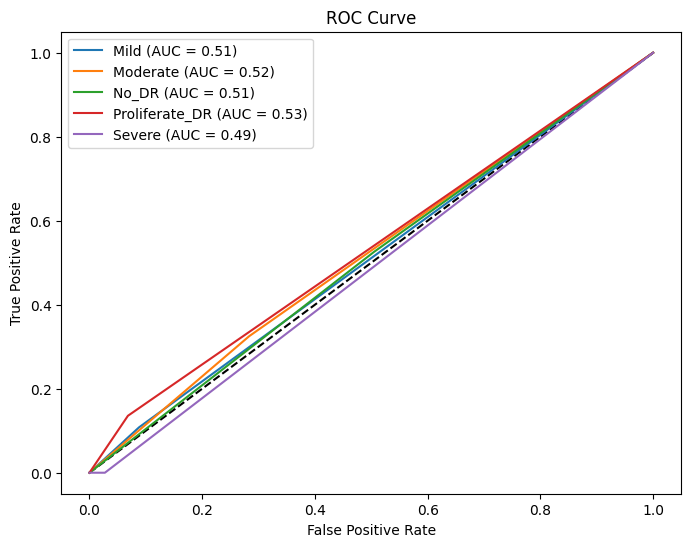

(            class  sensitivity  specificity
 0            Mild     0.911988     0.108108
 1        Moderate     0.716698     0.325000
 2           No_DR     0.494624     0.526316
 3  Proliferate_DR     0.931751     0.135593
 4          Severe     0.972622     0.000000,
 0.36971350613915416)

In [68]:
y_preds_ensemble_model = make_predictions(ensemble_model)
y_true = valid_data.classes
# Metrics for Ensemble_Model
metrics(y_true, y_preds_ensemble_model)

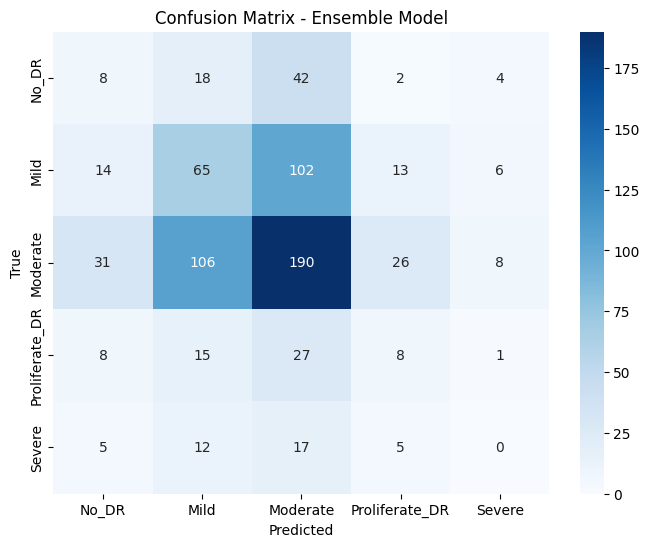

In [70]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_true_vgg16 and y_preds_vgg16 are defined previously
conf_matrix_ensemble = confusion_matrix(y_true, y_preds_ensemble_model)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ensemble, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No_DR', 'Mild', 'Moderate', 'Proliferate_DR', 'Severe'], 
            yticklabels=['No_DR', 'Mild', 'Moderate', 'Proliferate_DR', 'Severe'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Ensemble Model')
plt.show()

In [73]:
print(ensemble_model_history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


92/92 [==============================] - 11s 123ms/step


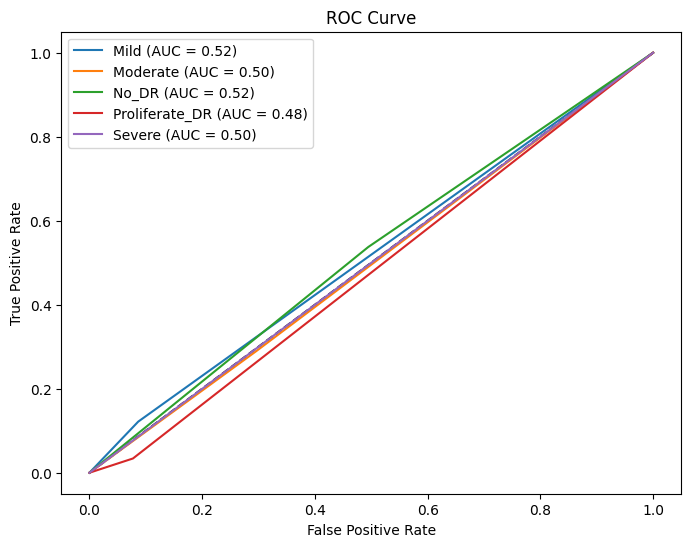

92/92 [==============================] - 11s 123ms/step


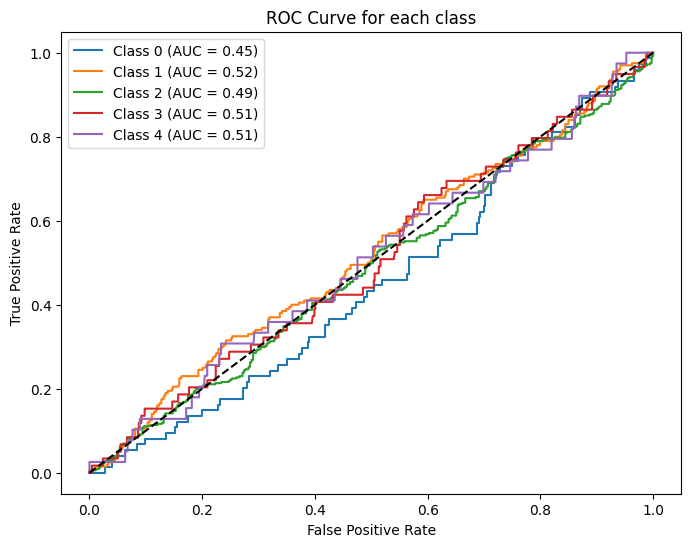

In [75]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ...

# Rest of your code for model training and evaluation...

# Obtain predictions for the validation set
y_preds_ensemble_model = make_predictions(ensemble_model)
y_true = valid_data.classes

# Metrics for denseNet
metrics(y_true, y_preds_ensemble_model)

# Plot ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()

# Obtain probabilities for each class
y_pred_probs = ensemble_model.predict(valid_data)

# Convert true labels to one-hot encoded form
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=5)

# Calculate ROC curve and AUC for each class
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC curves
plt.figure(figsize=(8, 6))
for i in range(5):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each class')
plt.legend(loc='best')
plt.show()